# Bitwise information content for all CAMS variables

In [3]:
using BitInformation
using JLD2, NetCDF

path = "/network/aopp/chaos/pred/kloewer/esowc/cams/"
filelist = filter(x->endswith(x,"_v3.nc"),readdir(path));

In [ ]:
n = length(filelist)
varnames = fill("",n)
nbits = 32

IC = fill(0.0,n,nbits)

for (i,file) in enumerate(filelist)
    varname = split(split(file,"cams_")[end],"_2019")[1]
    varnames[i] = varname
    print("$varname")
    ncfile = NetCDF.open(joinpath(path,file))
    
    # find the variable name by size
    var = [var for var in ncfile.vars if prod(size(var[2])) == 900*451*137][1][1]
    X = ncfile.vars[var][:,6:end-5,:]  # exclude north/southpole
    
    # convert biased exponent to signed exponent
    signed_exponent!(X)

    IC[i,:] = bitinformation(X,:all_dimensions)
    print("X, ")    

    @save joinpath(path,"..","analysis/bitinformation_all.jld2") varnames IC
end

In [4]:
@load joinpath(path,"..","analysis/bitinformation_all.jld2") varnames IC

2-element Vector{Symbol}:
 :varnames
 :IC

# Find bits with information

In [8]:
using Statistics, StatsBase

In [9]:
# filter out insignificant information based on pth percentile of the last byte
p = 100
nvars = length(varnames)

ICfilt = copy(IC)
for i in 1:nvars
    pthreshold = percentile(ICfilt[i,end-3:end],p)*1.1   # a bit bigger than noise
    i_insigni = argmax(diff(ICfilt[i,10:end] .< pthreshold))
    ICfilt[i,9+i_insigni:end] .= floatmin(Float64)
end

# for plotting replace zeros with NaN to get white
ICnan = copy(ICfilt)
ICnan[iszero.(ICfilt)] .= NaN;

In [10]:
ICcsum = cumsum(ICfilt,dims=2)
ICcsum_norm = copy(ICcsum)
for i in 1:nvars
    ICcsum_norm[i,:] ./= ICcsum_norm[i,end]
end

inflevel = 0.99
infbits = [argmax(ICcsum_norm[i,:] .> inflevel) for i in 1:nvars]
infbits100 = [argmax(ICcsum_norm[i,:] .> 0.999999999) for i in 1:nvars]

infbitsx = copy(vec(hcat(infbits,infbits)'))
infbitsx100 = copy(vec(hcat(infbits100,infbits100)'))
infbitsy = copy(vec(hcat(Array(0:nvars-1),Array(1:nvars))'));

In [11]:
@save joinpath(path,"../analysis/bits_to_retain.jld2") varnames infbits infbits100

## SORTING

In [ ]:
# sort and group
aero = vcat(1,32,57,collect(2:30))
ozone = [50,60,61]
methane = [42,43,56]
clouds = [38,44,45,48,49,67]
hydro = vcat(collect(51:55),62,31)
nitro = [58,59,68]
oopp = Array(63:66)
ces = vcat(collect(33:37),collect(39:41))
ceshydro = vcat(ces,hydro)
co12 = [46,47]

grouped = vcat(aero,co12,clouds,methane,ces,hydro,nitro,ozone,oopp)
groups = [aero,co12,clouds,methane,ces,hydro,nitro,ozone,oopp];

In [ ]:
# shorten "backscat" in varnames
for (i,varname) in enumerate(varnames)
    varnames[i] = replace(varname,"backscat"=>"")
end

In [ ]:
# sort
varnames = varnames[grouped]
ICg = infbits[grouped,:];

## PLOTTING

In [ ]:
using ColorSchemes, Printf, PyPlot

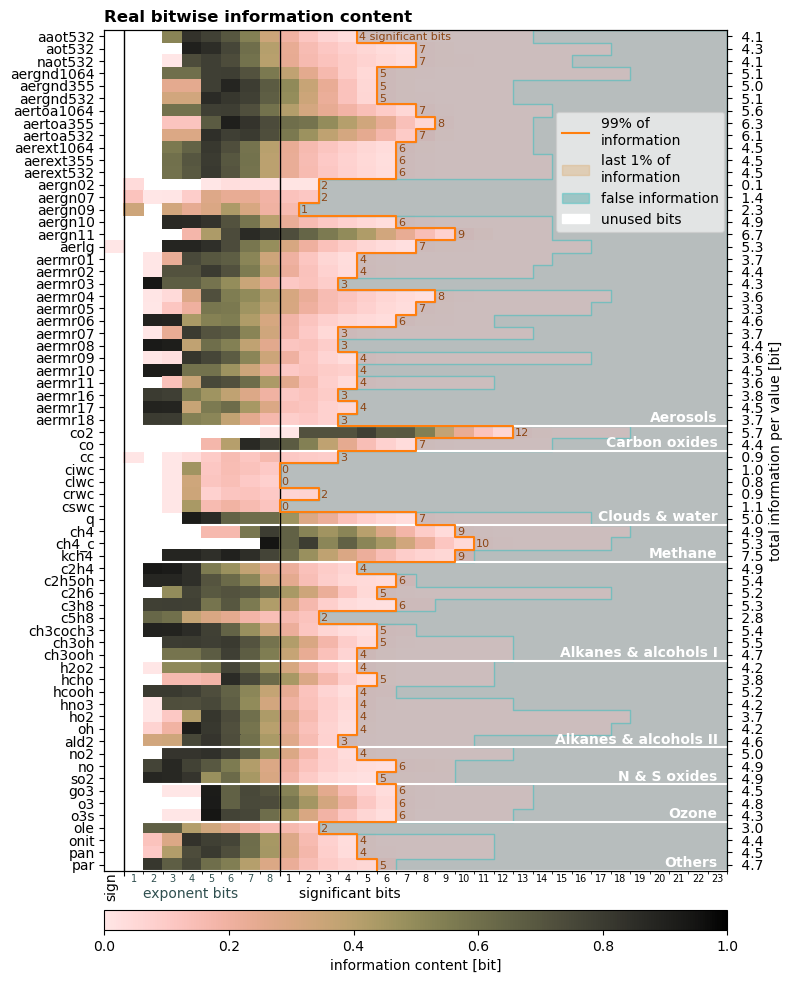

PyObject <matplotlib.legend.Legend object at 0x7f7641c04e50>

In [9]:
fig,ax1 = subplots(1,1,figsize=(8,10),sharey=true)
ax1.invert_yaxis()
tight_layout(rect=[0.06,0.08,0.93,0.98])
pos = ax1.get_position()
cax = fig.add_axes([pos.x0,0.06,pos.x1-pos.x0,0.02])

ax1right = ax1.twinx()
ax1right.invert_yaxis()

# information
cmap = ColorMap(ColorSchemes.turku.colors).reversed()
pcm = ax1.pcolormesh(ICnan,vmin=0,vmax=1;cmap)
cbar = colorbar(pcm,cax=cax,orientation="horizontal")
cbar.set_label("information content [bit]")

# 99% of real information enclosed
ax1.plot(vcat(infbits,infbits[end]),Array(0:nvars),"C1",ds="steps-pre",zorder=10,label="99% of\ninformation")

# grey shading
ax1.fill_betweenx(infbitsy,infbitsx,fill(32,length(infbitsx)),alpha=0.4,color="grey")
ax1.fill_betweenx(infbitsy,infbitsx100,fill(32,length(infbitsx)),alpha=0.1,color="c")
ax1.fill_betweenx(infbitsy,infbitsx100,fill(32,length(infbitsx)),alpha=0.3,facecolor="none",edgecolor="c")

# for legend only
ax1.fill_betweenx([-1,-1],[-1,-1],[-1,-1],color="burlywood",label="last 1% of\ninformation",alpha=.5)
ax1.fill_betweenx([-1,-1],[-1,-1],[-1,-1],facecolor="teal",edgecolor="c",label="false information",alpha=.3)
ax1.fill_betweenx([-1,-1],[-1,-1],[-1,-1],color="w",label="unused bits")

ax1.axvline(1,color="k",lw=1,zorder=3)
ax1.axvline(9,color="k",lw=1,zorder=3)

grouplabls = ["Aerosols","Carbon oxides","Clouds & water",
                "Methane","Alkanes & alcohols I","Alkanes & alcohols II",
                "N & S oxides","Ozone","Others"]

for (ig,group) in enumerate(groups)
    y = sum([length(g) for g in groups[1:ig]])
    ax1.axhline(y,color="w",lw=1.5,zorder=2)
    ax1.text(31.5,y-0.3,grouplabls[ig],color="w",ha="right",fontweight="bold")
end

ax1.set_title("Real bitwise information content",loc="left",fontweight="bold")

ax1.set_xlim(0,32)
ax1.set_ylim(nvars,0)
ax1right.set_ylim(nvars,0)

ax1.set_yticks(Array(1:nvars).-0.5)
ax1right.set_yticks(Array(1:nvars).-0.5)
ax1.set_yticklabels(varnames)
ax1right.set_yticklabels([@sprintf "%4.1f" i for i in ICcsum[:,end]])
ax1right.set_ylabel("total information per value [bit]")

ax1.text(infbits[1]+0.1,0.8,"$(infbits[1]-9) significant bits",fontsize=8,color="saddlebrown")
for i in 2:nvars
    ax1.text(infbits[i]+0.1,(i-1)+0.8,"$(infbits[i]-9)",fontsize=8,color="saddlebrown")
end

ax1.set_xticks([1,9])
ax1.set_xticks(vcat(2:8,10:32),minor=true)
ax1.set_xticklabels([])
ax1.text(0,nvars+2.2,"sign",rotation=90)
ax1.text(2,nvars+2.2,"exponent bits",color="darkslategrey")
ax1.text(10,nvars+2.2,"significant bits")

for i in 1:8
    ax1.text(i+.5,nvars+0.9,"$i",ha="center",fontsize=7,color="darkslategrey")
end

for i in 1:23
    ax1.text(8+i+.5,nvars+0.9,"$i",ha="center",fontsize=7)
end
    
ax1.legend(loc=(0.725,0.76),framealpha=0.6)

# savefig("../plots/bitinformation_all.png",dpi=100)